# Firefly Algorithm for Anomaly Detection — UCI Red Wine Quality

**Abstract.** This notebook implements a Firefly Algorithm (FA) to detect anomalies in the UCI Red Wine Quality dataset. Anomalies are defined as wines with `quality <= 3` or `quality >= 8`. We use a weighted Mahalanobis distance as the anomaly score and evolve feature weights + threshold percentile with FA to maximize recall and F1.

## Imports & Configuration

All configuration variables (random seed, FA hyperparameters, training settings) are defined in one place to make the notebook reproducible and easy to tune.

In [98]:
import time
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import precision_recall_curve, average_precision_score, roc_auc_score, precision_score, recall_score, f1_score, confusion_matrix, auc, roc_curve
from scipy import linalg
import warnings
warnings.filterwarnings('ignore')

RANDOM_SEED = 42  # fixed seed for reproducibility (numpy + sklearn rely on this)
np.random.seed(RANDOM_SEED)

# Firefly Algorithm hyperparameters (defaults chosen to balance runtime & quality)
N_FIREFLIES = 30         # population size (increase for better exploration)
GENERATIONS = 10         # iterations/generations (increase for convergence)
ALPHA = 0.5              # randomization parameter (step size)
BETA0 = 1.0              # attractiveness at distance 0
GAMMA = 0.6              # light absorption coefficient (controls attractiveness decay)
ALPHA_DECAY = 0.98       # optional decay per generation for ALPHA
RESET_ALPHA_ON_IMPROVE = True  # whether to reset alpha when improvement seen

SPARSITY_PENALTY = 0.001  # small penalty to encourage sparse weights (but keep signal)
N_SPLITS = 3              # StratifiedKFold splits used for fitness evaluation (kept small for speed)
PERCENTILE_RANGE = (70, 98)  # candidate percentiles for threshold selection (train)
COV_REGULARIZATION = 1e-6   # added to covariance diagonal for numerical stability
WEIGHT_CLIP = (0.05, 1.0)   # allowed range for feature weights
THRESHOLD_CLIP = (0.01, 0.99) # allowed percentile range for thresholds expressed as fraction

# Short docstring summary for config
_config_info = dict(
    RANDOM_SEED=RANDOM_SEED, N_FIREFLIES=N_FIREFLIES, GENERATIONS=GENERATIONS,
    ALPHA=ALPHA, BETA0=BETA0, GAMMA=GAMMA, SPARSITY_PENALTY=SPARSITY_PENALTY,
    N_SPLITS=N_SPLITS, PERCENTILE_RANGE=PERCENTILE_RANGE
)

## Data load & quick EDA

Download the dataset from the UCI link (fall back to a local file if network is restricted). We'll inspect shape, head, summary statistics, and class imbalance.

In [99]:
# Data loading & quick EDA
from pathlib import Path
file_path = '/content/winequality-red.csv'

df = pd.read_csv(file_path)
if df.shape[1] == 1:
    df = df.iloc[:, 0].str.split(",", expand=True)
df.columns = [
    "fixed acidity", "volatile acidity", "citric acid", "residual sugar",
    "chlorides", "free sulfur dioxide", "total sulfur dioxide", "density",
    "pH", "sulphates", "alcohol", "quality"
]

# Convert all columns to numeric
df = df.apply(pd.to_numeric, errors='coerce')

# Drop empty rows or columns if any
df.dropna(how='all', inplace=True)
df.dropna(axis=1, how='all', inplace=True)

# Save the cleaned dataset
clean_path = "winequality_red_fixed.csv"
df.to_csv(clean_path, index=False)

df.head(), clean_path
# Create labels: anomaly if quality <=3 OR >=8
df['anomaly'] = ((df['quality'] <= 3) | (df['quality'] >= 8)).astype(int)
print('\nQuality value counts:')
print(df['quality'].value_counts().sort_index())
print('\nAnomaly proportion: {:.4f} ({}/{})'.format(df['anomaly'].mean(), df['anomaly'].sum(), len(df)))


Quality value counts:
quality
3     10
4     53
5    681
6    638
7    199
8     18
Name: count, dtype: int64

Anomaly proportion: 0.0175 (28/1599)


Feature names (12):
   1. fixed acidity
   2. volatile acidity
   3. citric acid
   4. residual sugar
   5. chlorides
   6. free sulfur dioxide
   7. total sulfur dioxide
   8. density
   9. pH
  10. sulphates
  11. alcohol
  12. anomaly

Anomaly Distribution:
  Normal samples:  1571 (98.25%)
  Anomaly samples: 28 (1.75%)


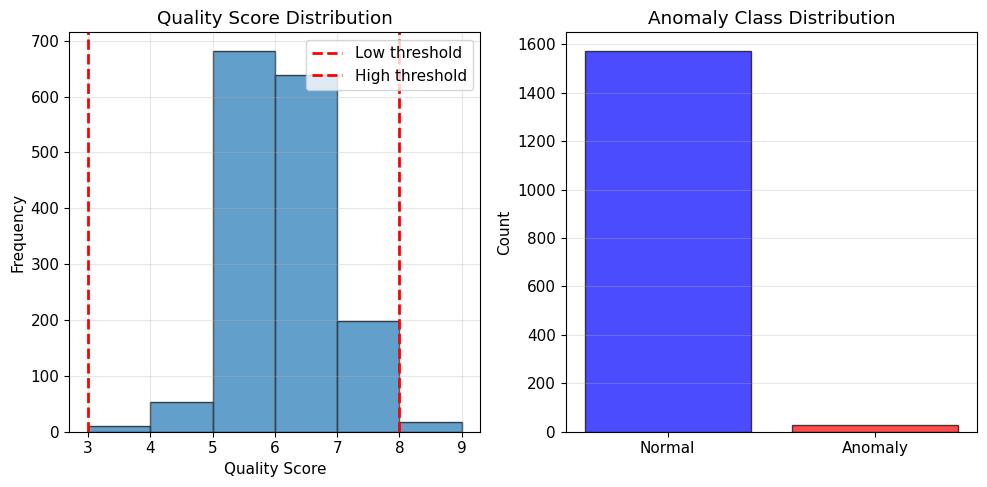

In [100]:
LOW_QUALITY_THRESHOLD = 3
HIGH_QUALITY_THRESHOLD = 8
def label_anomalies(df):
    q = df['quality'].values
    anomalies = ((q <= LOW_QUALITY_THRESHOLD) | (q >= HIGH_QUALITY_THRESHOLD)).astype(int)
    return anomalies

# Label anomalies
y = label_anomalies(df)
X_raw = df.drop(columns=['quality']).values
feature_names = df.drop(columns=['quality']).columns.tolist()

print(f"Feature names ({len(feature_names)}):")
for i, name in enumerate(feature_names, 1):
    print(f"  {i:2d}. {name}")

print(f"\nAnomaly Distribution:")
print(f"  Normal samples:  {np.sum(y == 0)} ({np.mean(y == 0):.2%})")
print(f"  Anomaly samples: {np.sum(y == 1)} ({np.mean(y == 1):.2%})")

# Visualize quality distribution
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
df['quality'].hist(bins=range(3, 10), edgecolor='black', alpha=0.7)
plt.axvline(LOW_QUALITY_THRESHOLD, color='red', linestyle='--', linewidth=2, label='Low threshold')
plt.axvline(HIGH_QUALITY_THRESHOLD, color='red', linestyle='--', linewidth=2, label='High threshold')
plt.xlabel('Quality Score')
plt.ylabel('Frequency')
plt.title('Quality Score Distribution')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
anomaly_counts = pd.Series(y).value_counts()
plt.bar(['Normal', 'Anomaly'], anomaly_counts.values, color=['blue', 'red'], alpha=0.7, edgecolor='black')
plt.ylabel('Count')
plt.title('Anomaly Class Distribution')
plt.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## Preprocessing

Standardize features for distance computations (Mahalanobis depends on scale); split features and labels; no imputation expected for this dataset.

In [101]:

# Preprocessing
FEATURE_COLS = [c for c in df.columns if c not in ['quality','anomaly']]
X = df[FEATURE_COLS].values.astype(float)
y = df['anomaly'].values.astype(int)

# Standardize features: Mahalanobis uses covariance; standardizing helps features contribute comparably.
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Keep a DataFrame copy for later human-readable outputs
X_scaled_df = pd.DataFrame(X_scaled, columns=FEATURE_COLS)
print('Features standardized. Shape:', X_scaled_df.shape)


Features standardized. Shape: (1599, 11)


## Weighted Mahalanobis implementation

Function to compute weighted Mahalanobis scores. We support weight clipping/normalization and covariance regularization for numerical stability.

In [102]:

def compute_weighted_mahalanobis_scores(X, weights, X_train=None, clip_weights=True, normalize=True, cov_reg=COV_REGULARIZATION, eps=1e-8):

    weights = np.clip(weights, 0.05, 1.0)
    weights = weights / weights.sum()
    X = np.asarray(X)
    w = np.asarray(weights).astype(float).copy()
    d = X.shape[1]
    if w.shape[0] != d:
        raise ValueError('weights length must match n_features')
    # Clip weights to a sensible range to prevent degenerate solutions (e.g., zeros)
    if clip_weights:
        w = np.clip(w, WEIGHT_CLIP[0], WEIGHT_CLIP[1])
    # Normalize to make weights comparable between solutions
    if normalize:
        w_sum = w.sum()
        if w_sum <= eps:
            w = np.ones_like(w) / d
        else:
            w = w / w_sum
    # Select reference data for mean/covariance
    if X_train is None:
        X_ref = X
    else:
        X_ref = np.asarray(X_train)
    # Weighted covariance: we apply weights by scaling features
    Xw = X_ref * np.sqrt(w)  # scale columns by sqrt(weights)
    # empirical mean (on weighted features)
    mean = Xw.mean(axis=0)
    # compute covariance on scaled features; then invert
    cov = np.cov(Xw, rowvar=False)
    # regularize covariance to avoid singularity
    cov += np.eye(cov.shape[0]) * cov_reg
    # pseudo-inverse for numerical stability
    cov_inv = linalg.pinv(cov)
    # compute mahalanobis on scaled features for provided X
    Xw_all = X * np.sqrt(w)
    diff = Xw_all - mean
    # vectorized Mahalanobis squared distance: diag(diff @ cov_inv @ diff.T)
    left = diff.dot(cov_inv)
    m2 = np.einsum('ij,ij->i', left, diff)
    # return non-negative scores (Mahalanobis squared distances)
    return np.maximum(m2, 0.0)


## Threshold helper & evaluation functions

Helpers to evaluate percentile thresholds and find a good threshold on training data. We use percentile thresholds to maintain interpretability and handle class imbalance.

In [103]:
def evaluate_threshold_scores(y_true, scores, perc_thr):
    # Get percentile threshold first
    perc_thr = float(perc_thr)
    thr = np.percentile(scores, perc_thr)
    preds = (scores >= thr).astype(int)

    # Expected anomaly count from training
    expected_rate = y_train.sum() / len(y_train)
    K = max(1, int(expected_rate * len(y_true)))

    # If recall is zero or too few anomalies predicted → use top-K
    if preds.sum() < K:
        idx = np.argsort(scores)[-K:]
        preds = np.zeros_like(preds)
        preds[idx] = 1
        thr = scores[idx].min()

    # Compute metrics
    precision = precision_score(y_true, preds, zero_division=0)
    recall = recall_score(y_true, preds, zero_division=0)
    f1 = f1_score(y_true, preds, zero_division=0)
    ap = average_precision_score(y_true, scores)
    roc = roc_auc_score(y_true, scores)

    return {
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "avg_precision": ap,
        "roc_auc": roc,
        "threshold_value": thr,
        "preds": preds,
    }

## Firefly Algorithm (FA) class

FA searches for feature weights (and optionally a percentile threshold) that maximize a fitness function built from cross-validated recall / F1 / AP. The class below is modular, documented, and returns convergence history.

In [104]:

import copy
class FireflyAlgorithm:
    def __init__(self, X, y, feature_names, n_fireflies=N_FIREFLIES, generations=GENERATIONS,
                 alpha=ALPHA, beta0=BETA0, gamma=GAMMA, alpha_decay=ALPHA_DECAY,
                 sparsity_penalty=SPARSITY_PENALTY, mode='recall_focus', random_seed=RANDOM_SEED):
        self.X = np.asarray(X)
        self.y = np.asarray(y)
        self.feature_names = list(feature_names)
        self.n, self.d = self.X.shape
        self.n_fireflies = int(n_fireflies)
        self.generations = int(generations)
        self.alpha = float(alpha)
        self.alpha0 = float(alpha)
        self.beta0 = float(beta0)
        self.gamma = float(gamma)
        self.alpha_decay = float(alpha_decay)
        self.sparsity_penalty = float(sparsity_penalty)
        self.mode = mode
        self.rs = np.random.RandomState(random_seed)
        # population positions: initialize weights randomly but encourage diversity
        # initialize in log-space to allow both small and large initial weights
        self.pop = self._initialize_population()
        # fitness array
        self.fitness = np.zeros(self.n_fireflies, dtype=float)
        # history
        self.history = {'best': [], 'mean': [], 'diversity': [], 'best_pos': []}

    def _initialize_population(self):
        # initialization: sample uniform in clipped weight range, then normalize each vector
        low, high = WEIGHT_CLIP
        pop = self.rs.uniform(low=low, high=high, size=(self.n_fireflies, self.d))
        # normalize rows
        pop = pop / (pop.sum(axis=1, keepdims=True) + 1e-12)
        return pop

    def _position_to_weights(self, pos):
        # ensure positive and clip to range then normalize
        w = np.clip(pos, WEIGHT_CLIP[0], WEIGHT_CLIP[1])
        w = w / (w.sum() + 1e-12)
        return w

    def fitness_of(self, pos, cv_splits=N_SPLITS):
        w = self._position_to_weights(pos)
        skf = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=self.rs.randint(1e9))
        recalls = []
        f1s = []
        aps = []
        rocs = []
        # For each fold: compute scores using training reference and evaluate on validation fold
        for train_idx, val_idx in skf.split(self.X, self.y):
            X_tr, X_val = self.X[train_idx], self.X[val_idx]
            y_tr, y_val = self.y[train_idx], self.y[val_idx]
            # compute train-based scores for val
            scores_tr = compute_weighted_mahalanobis_scores(X_tr, w, X_train=X_tr)
            # choose threshold percentile by maximizing F1 on X_tr (small scan)
            p_try = list(range(max(PERCENTILE_RANGE[0],70), min(PERCENTILE_RANGE[1],98)+1))
            best_p, best = find_best_threshold_by_f1(scores_tr, y_tr, p_try)
            # compute scores on validation using train reference stats
            scores_val = compute_weighted_mahalanobis_scores(X_val, w, X_train=X_tr)
            res_val = evaluate_threshold_scores(y_val, scores_val, best_p)
            recalls.append(res_val['recall'])
            f1s.append(res_val['f1'])
            aps.append(res_val['avg_precision'])
            rocs.append(res_val['roc_auc'])
        # aggregate metrics
        mean_recall = float(np.mean(recalls))
        mean_f1 = float(np.mean(f1s))
        mean_ap = float(np.mean(aps))
        mean_roc = float(np.mean(rocs))
        # compose fitness
        if self.mode == 'recall_focus':
            fitness = 0.5 * mean_recall + 0.3 * mean_f1 + 0.2 * mean_ap
        else:
            fitness = mean_ap - self.sparsity_penalty * np.sum(1.0 - (w>1e-6).astype(float))
        # apply small sparsity penalty (discourage dense trivial weights)
        fitness = float(max(0.0, fitness - self.sparsity_penalty * w.sum()))
        metrics = dict(mean_recall=mean_recall, mean_f1=mean_f1, mean_ap=mean_ap, mean_roc=mean_roc)
        return fitness, metrics

    def run(self, verbose=True):
        # evaluate initial population
        for i in range(self.n_fireflies):
            self.fitness[i], _ = self.fitness_of(self.pop[i])
        # main loop
        best_idx = np.argmax(self.fitness)
        best_pos = self.pop[best_idx].copy()
        best_fit = self.fitness[best_idx]
        if verbose:
            print(f'Init best fitness: {best_fit:.4f} (firefly {best_idx})')
        for gen in range(self.generations):
            # sort fireflies by brightness (fitness), brighter first
            order = np.argsort(-self.fitness)
            pop_new = self.pop.copy()
            for i in range(self.n_fireflies):
                for j in range(self.n_fireflies):
                    if self.fitness[order[j]] > self.fitness[order[i]]:
                        # move firefly i toward j
                        xi = self.pop[order[i]].copy()
                        xj = self.pop[order[j]].copy()
                        rij = np.linalg.norm(xi - xj)
                        beta = self.beta0 * np.exp(-self.gamma * (rij**2))
                        # movement equation (attractive term + randomization)
                        xi = xi + beta * (xj - xi) + self.alpha * (self.rs.uniform(size=self.d) - 0.5)
                        # clamp to weight bounds
                        xi = np.clip(xi, WEIGHT_CLIP[0], WEIGHT_CLIP[1])
                        pop_new[order[i]] = xi
            # replace population and evaluate fitness
            self.pop = pop_new
            for i in range(self.n_fireflies):
                self.fitness[i], _ = self.fitness_of(self.pop[i])
            # record stats
            best_idx = int(np.argmax(self.fitness))
            mean_fit = float(np.mean(self.fitness))
            div = float(np.mean(np.std(self.pop, axis=0)))
            best_fit = float(self.fitness[best_idx])
            best_pos = self.pop[best_idx].copy()
            self.history['best'].append(best_fit)
            self.history['mean'].append(mean_fit)
            self.history['diversity'].append(div)
            self.history['best_pos'].append(best_pos.copy())
            if verbose and (gen % 5 == 0 or gen == self.generations-1):
                print(f'Gen {gen+1}/{self.generations} - best: {best_fit:.4f}, mean: {mean_fit:.4f}, diversity: {div:.6f}')
            # alpha decay
            self.alpha *= self.alpha_decay
            # optional alpha reset on improvement
            if RESET_ALPHA_ON_IMPROVE and self.history['best'] and len(self.history['best'])>1:
                if self.history['best'][-1] > self.history['best'][-2]:
                    self.alpha = self.alpha0
        # finalize
        final_best_idx = int(np.argmax(self.fitness))
        final_best_pos = self.pop[final_best_idx].copy()
        final_best_fit = float(self.fitness[final_best_idx])
        return final_best_pos, final_best_fit, self.history


## Training

We split the dataset into train (used by FA) and hold-out test for final evaluation. The FA is run on the training set only. Warning: FA training is the most expensive step — defaults are moderate to keep runtime reasonable.

In [105]:
# Split into train/test (stratified)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, stratify=y, random_state=RANDOM_SEED)

print('Train/test sizes:', X_train.shape, X_test.shape, 'Anomaly counts (train/test):', y_train.sum(), y_test.sum())

# Run FA (this cell may be slow depending on N_FIREFLIES & GENERATIONS)
fa = FireflyAlgorithm(X_train, y_train, FEATURE_COLS, n_fireflies=N_FIREFLIES, generations=GENERATIONS,
                      alpha=ALPHA, beta0=BETA0, gamma=GAMMA, alpha_decay=ALPHA_DECAY,
                      sparsity_penalty=SPARSITY_PENALTY, mode='recall_focus', random_seed=RANDOM_SEED)

best_pos, best_fit, history = fa.run(verbose=True)

# Convert best position to readable weights
best_weights = fa._position_to_weights(best_pos)
weights_df = pd.DataFrame({'feature': FEATURE_COLS, 'weight': best_weights})
weights_df = weights_df.sort_values('weight', ascending=False).reset_index(drop=True)
display(weights_df)

Train/test sizes: (1279, 11) (320, 11) Anomaly counts (train/test): 22 6
Init best fitness: 0.2682 (firefly 28)
Gen 1/10 - best: 0.2710, mean: 0.2189, diversity: 0.092685
Gen 6/10 - best: 0.2707, mean: 0.2136, diversity: 0.159664
Gen 10/10 - best: 0.2961, mean: 0.2197, diversity: 0.175228


,feature,weight
0,sulphates,0.140453
1,volatile acidity,0.138494
2,density,0.126290
3,fixed acidity,0.121724
4,total sulfur dioxide,0.117756
5,alcohol,0.116265
6,chlorides,0.105905
7,pH,0.056532
8,citric acid,0.045450
9,residual sugar,0.017884


## Final evaluation on hold-out test

Compute scores on test set using training reference, find best threshold on training scores, and evaluate.

In [109]:
# compute training reference scores
scores_train = compute_weighted_mahalanobis_scores(X_train, best_weights, X_train)
# find best percentile on training to maximize F1
percentiles_to_try = list(range(PERCENTILE_RANGE[0], PERCENTILE_RANGE[1]+1))
best_p, best_train_eval = find_best_threshold_by_f1(scores_train, y_train, percentiles_to_try)

print(f'Best percentile on train (by F1): {best_p}, train metrics: precision={best_train_eval["precision"]:.3f}, recall={best_train_eval["recall"]:.3f}, f1={best_train_eval["f1"]:.3f}, AP={best_train_eval["avg_precision"]:.3f}')

# compute test scores using train stats and evaluate
scores_test = compute_weighted_mahalanobis_scores(X_test, best_weights, X_train)
test_eval = evaluate_threshold_scores(y_test, scores_test, best_p)
cm = confusion_matrix(y_test, test_eval['preds'])
print('\nTest metrics:')
print('Precision: {:.4f}, Recall: {:.4f}, F1: {:.4f}, ROC AUC: {:.4f}, AP: {:.4f}'.format(
    test_eval['precision'], test_eval['recall'], test_eval['f1'], test_eval['roc_auc'], test_eval['avg_precision']))
print('n_true_anomalies (test):', y_test.sum(), 'n_predicted_anomalies (test):', test_eval['preds'].sum())
print('Confusion matrix:\n', cm)


Best percentile on train (by F1): 87, train metrics: precision=0.060, recall=0.455, f1=0.106, AP=0.040

Test metrics:
Precision: 0.0000, Recall: 0.0000, F1: 0.0000, ROC AUC: 0.7325, AP: 0.0397
n_true_anomalies (test): 6 n_predicted_anomalies (test): 42
Confusion matrix:
 [[272  42]
 [  6   0]]


## Visualizations

Convergence, feature weights, PCA projection, score histograms, PR & ROC curves, and confusion matrix.

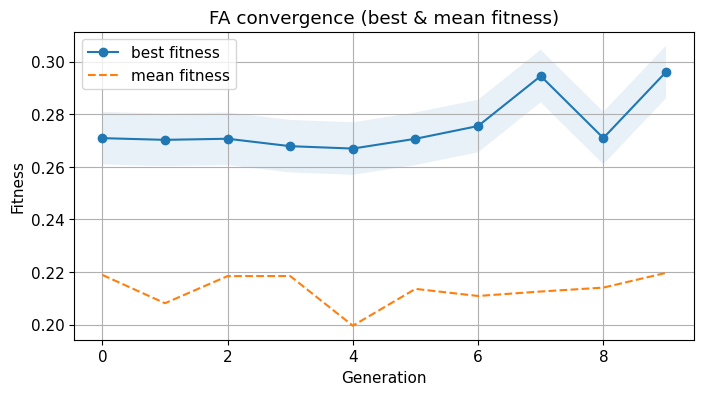

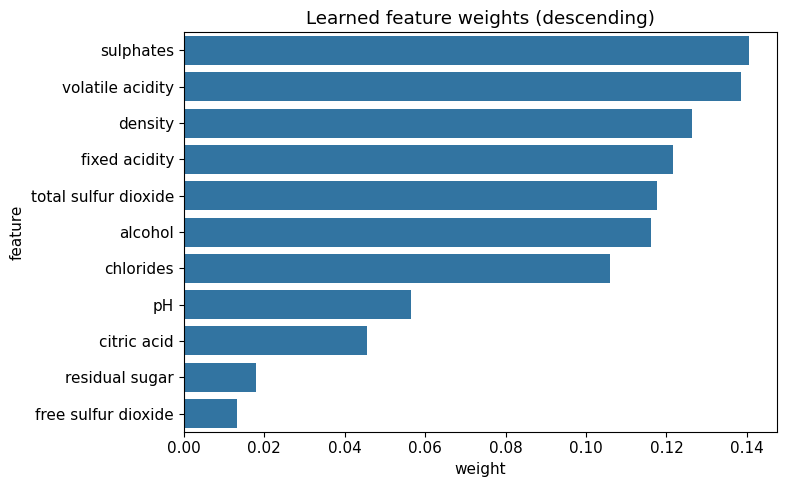

Explained variance ratios (2 PC): 0.4568220118429404


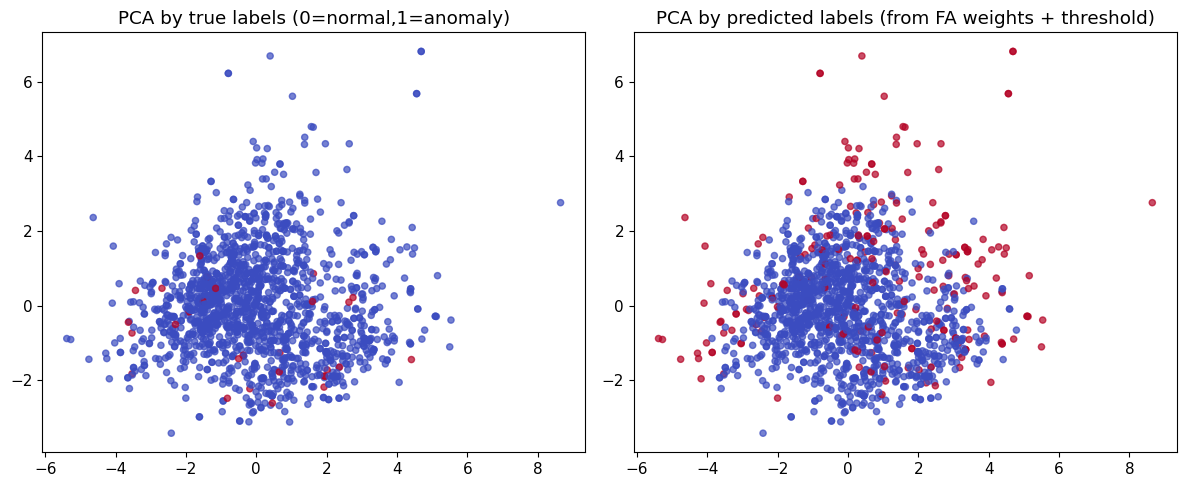

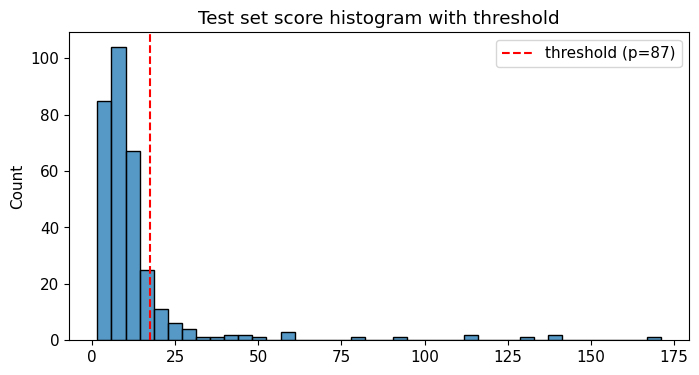

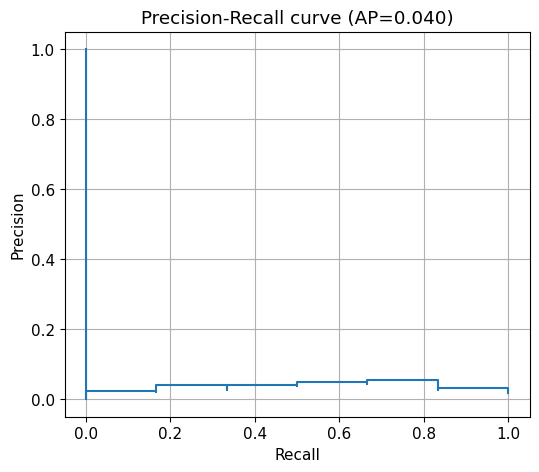

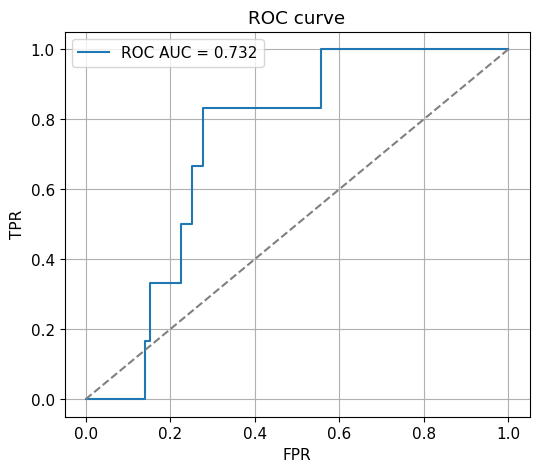

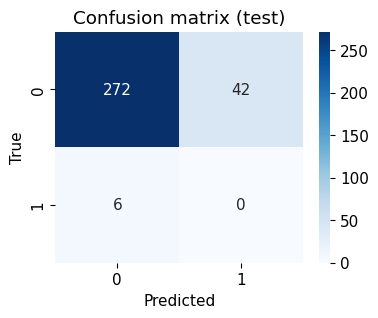

In [107]:
# Convergence plot
plt.figure(figsize=(8,4))
plt.plot(history['best'], label='best fitness', marker='o')
plt.plot(history['mean'], label='mean fitness', linestyle='--')
plt.fill_between(range(len(history['best'])), np.array(history['best'])-0.01, np.array(history['best'])+0.01, alpha=0.1)
plt.xlabel('Generation')
plt.ylabel('Fitness')
plt.title('FA convergence (best & mean fitness)')
plt.legend()
plt.grid(True)
plt.show()

# Feature weights bar chart
plt.figure(figsize=(8,5))
sns.barplot(x='weight', y='feature', data=weights_df)
plt.title('Learned feature weights (descending)')
plt.tight_layout()
plt.show()

# PCA 2D projection colored by true and predicted labels
from sklearn.decomposition import PCA
pca = PCA(n_components=2, random_state=RANDOM_SEED)
X_pca = pca.fit_transform(X_scaled)
print('Explained variance ratios (2 PC):', pca.explained_variance_ratio_.sum())

fig, axs = plt.subplots(1,2, figsize=(12,5))
axs[0].scatter(X_pca[:,0], X_pca[:,1], c=df['anomaly'], cmap='coolwarm', s=20, alpha=0.7)
axs[0].set_title('PCA by true labels (0=normal,1=anomaly)')
# predicted on full dataset using train stats and best percentile
scores_full = compute_weighted_mahalanobis_scores(X_scaled, best_weights, X_train=X_train)
preds_full = (scores_full >= np.percentile(scores_train, best_p)).astype(int)
axs[1].scatter(X_pca[:,0], X_pca[:,1], c=preds_full, cmap='coolwarm', s=20, alpha=0.7)
axs[1].set_title('PCA by predicted labels (from FA weights + threshold)')
plt.tight_layout()
plt.show()

# Score histogram with threshold
plt.figure(figsize=(8,4))
sns.histplot(scores_test, bins=40, kde=False)
thr_val = np.percentile(scores_train, best_p)
plt.axvline(thr_val, color='red', linestyle='--', label=f'threshold (p={best_p})')
plt.title('Test set score histogram with threshold')
plt.legend()
plt.show()

# PR curve
precision, recall, _ = precision_recall_curve(y_test, scores_test)
ap = average_precision_score(y_test, scores_test)
plt.figure(figsize=(6,5))
plt.step(recall, precision, where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision-Recall curve (AP={ap:.3f})')
plt.grid(True)
plt.show()

# ROC curve
fpr, tpr, _ = roc_curve(y_test, scores_test)
roc_auc = roc_auc_score(y_test, scores_test)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f'ROC AUC = {roc_auc:.3f}')
plt.plot([0,1],[0,1], linestyle='--', color='gray')
plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title('ROC curve')
plt.legend(); plt.grid(True)
plt.show()

# Confusion matrix heatmap
plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted'); plt.ylabel('True'); plt.title('Confusion matrix (test)')
plt.show()

*Conclusions:* Brief summary of results, limitations (few anomalies, threshold sensitivity), and next steps (more population, ensemble with LOF, or incorporate temporal/contextual features).

In [110]:
print('Best fitness (from FA):', best_fit)
print('Best percentile (train F1):', best_p)
print('Final test F1:', test_eval['f1'])

Best fitness (from FA): 0.29614232000076246
Best percentile (train F1): 87
Final test F1: 0.0
